# Análise de Sentimento Financeiro

Neste notebook, buscamos entender o sentimento financeiro por meio de análises de sentimentos em textos. O objetivo é classificar os sentimentos expressos em textos financeiros como positivos, negativos ou neutros.

Essa tarefa se faz necessária devido à crescente quantidade de dados financeiros disponíveis, como notícias, relatórios e comentários de analistas. A análise de sentimentos pode ajudar investidores e analistas a tomar decisões informadas com base nas emoções expressas nesses textos. É uma ferramenta diretamente aplicável ao feedback de clientes, relatórios financeiros e até mesmo em redes sociais, onde as opiniões sobre ações e mercados podem influenciar o comportamento do mercado.


In [1]:
# Manipulação e análise de dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento de texto e NLP
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sentence_transformers import SentenceTransformer

# Representação e modelagem de texto
import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

# Machine Learning
from sklearn.model_selection import KFold, train_test_split, cross_validate, cross_val_score, GridSearchCV, \
    RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

# Avaliação de modelos
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer, f1_score, \
    precision_score, recall_score

# Utilitários
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.exceptions import ConvergenceWarning
import warnings
from typing import Dict, List, Set, Tuple, Optional

# Configurações
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Downloads necessários do NLTK
try:
    nltk.wordnet.WordNetLemmatizer()
except LookupError:
    nltk.download('wordnet', quiet=True)

try:
    nltk.data.find('corpora/omw-1.4')
except LookupError:
    nltk.download('omw-1.4', quiet=True)

/home/apo-pc/anaconda3/envs/DS-Mandacaru/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/home/apo-pc/anaconda3/envs/DS-Mandacaru/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Funções Auxiliares

In [2]:
def load_loughran_mcdonald(file_path: str, categories: List[str] = None) -> Dict[str, Set[str]]:
    """
    Carrega o dicionário Loughran-McDonald de um arquivo CSV.

    Args:
        file_path: Caminho para o arquivo CSV do dicionário LM
        categories: Lista de categorias a serem carregadas


    Returns:
        Dicionário com sets de palavras por categoria
    """
    if categories is None:
        categories = ['Positive', 'Negative', 'Uncertainty', 'Litigious',
                     'Strong_Modal', 'Weak_Modal', 'Constraining']

    lexicons = {cat: set() for cat in categories}

    try:
        df = pd.read_csv(file_path, usecols=['Word'] + categories,
                        keep_default_na=False, na_values=[''])

        for category in categories:
            if category in df.columns:
                numeric_col = pd.to_numeric(df[category], errors='coerce')
                mask = numeric_col.notna() & (numeric_col > 0)
                words = df.loc[mask, 'Word']
                lexicons[category].update(word.upper() for word in words if isinstance(word, str))

        print(f"Dicionário LM carregado: {file_path}")

    except FileNotFoundError:
        print(f"Arquivo não encontrado: {file_path}")
        print("Continuando com dicionários vazios...")
    except Exception as e:
        print(f"Erro ao carregar dicionário: {e}")

    return lexicons

# =============================================================================
# ENGENHARIA DE FEATURES
# =============================================================================

def tokenize_text(text: str) -> List[str]:
    """Tokeniza texto e converte para maiúsculas (padrão LM)."""
    if pd.isna(text):
        return []
    return [word.upper() for word in re.findall(r'\b\w+\b', str(text))]

def count_lexicon_words(tokens: List[str], word_set: Set[str]) -> int:
    """Conta palavras que estão no conjunto de léxico."""
    return sum(1 for word in tokens if word in word_set)

def calculate_basic_features(df: pd.DataFrame, text_column: str = 'Sentence') -> pd.DataFrame:
    """Calcula features básicas de texto."""
    result = df.copy()

    # Features básicas
    result['tamanho_texto'] = result[text_column].str.len().fillna(0)
    result['tokens'] = result[text_column].apply(tokenize_text)
    result['qtd_palavras'] = result['tokens'].apply(len)
    result['qtd_exclamacao'] = result[text_column].str.count(r'\!').fillna(0)
    result['qtd_interrogacao'] = result[text_column].str.count(r'\?').fillna(0)
    result['razao_caixa_alta'] = result[text_column].apply(
        lambda x: sum(c.isupper() for c in str(x)) / len(str(x)) if len(str(x)) > 0 else 0
    )

    return result

def calculate_lm_features(df: pd.DataFrame, lm_lexicons: Dict[str, Set[str]]) -> pd.DataFrame:
    """Calcula features baseadas no dicionário Loughran-McDonald."""
    result = df.copy()

    # Features LM
    result['lm_positive'] = result['tokens'].apply(
        lambda tokens: count_lexicon_words(tokens, lm_lexicons.get('Positive', set()))
    )
    result['lm_negative'] = result['tokens'].apply(
        lambda tokens: count_lexicon_words(tokens, lm_lexicons.get('Negative', set()))
    )
    result['lm_uncertainty'] = result['tokens'].apply(
        lambda tokens: count_lexicon_words(tokens, lm_lexicons.get('Uncertainty', set()))
    )
    result['lm_litigious'] = result['tokens'].apply(
        lambda tokens: count_lexicon_words(tokens, lm_lexicons.get('Litigious', set()))
    )
    result['lm_constraining'] = result['tokens'].apply(
        lambda tokens: count_lexicon_words(tokens, lm_lexicons.get('Constraining', set()))
    )

    # Score de sentimento
    result['lm_sentiment_score'] = result['lm_positive'] - result['lm_negative']

    return result

def create_all_features(df: pd.DataFrame, lm_lexicons: Dict[str, Set[str]],
                       text_column: str = 'Sentence') -> pd.DataFrame:
    """Cria todas as features necessárias."""
    # Features básicas
    df_features = calculate_basic_features(df, text_column)

    # Features LM
    df_features = calculate_lm_features(df_features, lm_lexicons)

    # Remove coluna de tokens (não é feature)
    df_features = df_features.drop(columns=['tokens'])

    # Preenche NaNs
    feature_columns = [col for col in df_features.columns
                      if col not in [text_column, 'Sentiment']]
    for col in feature_columns:
        df_features[col] = df_features[col].fillna(0)

    return df_features

# =============================================================================
# ANÁLISE ESTATÍSTICA
# =============================================================================

def balance_dataset(df: pd.DataFrame, target_column: str = 'Sentiment',
                   random_state: int = 42) -> pd.DataFrame:
    """Balanceia dataset através de subamostragem."""
    class_counts = df[target_column].value_counts()
    min_size = class_counts.min()

    balanced_dfs = []
    for class_label in class_counts.index:
        class_df = df[df[target_column] == class_label]
        sampled_df = class_df.sample(n=min_size, random_state=random_state)
        balanced_dfs.append(sampled_df)

    balanced_df = pd.concat(balanced_dfs).sample(frac=1, random_state=random_state).reset_index(drop=True)

    print(f"Dataset balanceado: {len(balanced_df)} amostras ({min_size} por classe)")
    return balanced_df

def test_feature_significance(df: pd.DataFrame, features: List[str],
                            target_column: str = 'Sentiment',
                            alpha: float = 0.05, show_output = False) -> Dict:
    """Testa significância estatística das features usando Kruskal-Wallis."""
    results = {}
    classes = sorted(df[target_column].unique())

    print(f"Testando {len(features)} features (alpha={alpha})")
    print("=" * 50)

    for feature in features:
        if show_output:
            print(f"\nFeature: {feature}")

        # Dados por grupo
        groups = [df[df[target_column] == cls][feature].dropna() for cls in classes]
        valid_groups = [group for group in groups if len(group) > 1]

        if len(valid_groups) < 2:
            print(f"  Dados insuficientes para teste")
            results[feature] = {'p_value': np.nan, 'significant': False, 'statistic': np.nan}
            continue

        try:
            statistic, p_value = stats.kruskal(*valid_groups)
            significant = p_value < alpha

            results[feature] = {
                'p_value': p_value,
                'significant': significant,
                'statistic': statistic
            }


            status = "Significativo" if significant else "Não significativo"
            if show_output:
                print(f"  Kruskal-Wallis: H={statistic:.3f}, p={p_value:.4f} - {status}")

        except Exception as e:
            print(f"  Erro no teste: {e}")
            results[feature] = {'p_value': np.nan, 'significant': False, 'statistic': np.nan}

    return results

def summarize_results(results: Dict) -> None:
    """Resumo dos resultados dos testes."""
    significant_features = [feat for feat, res in results.items()
                          if res['significant'] and not np.isnan(res['p_value'])]

    print("\n" + "=" * 50)
    print("RESUMO DOS RESULTADOS")
    print("=" * 50)

    print(f"\nFeatures significativas ({len(significant_features)}):")
    if significant_features:
        for feat in significant_features:
            p_val = results[feat]['p_value']
            print(f"  - {feat}: p={p_val:.4f}")
    else:
        print("  Nenhuma feature significativa encontrada")

    print(f"\nTotal de features testadas: {len(results)}")
    print(f"Features com dados válidos: {sum(1 for r in results.values() if not np.isnan(r['p_value']))}")

# =============================================================================
# VISUALIZAÇÃO
# =============================================================================

def plot_feature_distributions(df: pd.DataFrame, features: List[str],
                             target_column: str = 'Sentiment',
                             max_plots: int = 6) -> None:
    """Plota distribuições das features por classe."""
    features_to_plot = features[:max_plots]
    n_features = len(features_to_plot)

    if n_features == 0:
        return

    cols = min(3, n_features)
    rows = (n_features + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    if n_features == 1:
        axes = [axes]
    elif rows == 1:
        axes = [axes] if cols == 1 else axes
    else:
        axes = axes.flatten()

    classes = sorted(df[target_column].unique())

    for i, feature in enumerate(features_to_plot):
        ax = axes[i] if n_features > 1 else axes[0]

        sns.boxplot(data=df, x=target_column, y=feature, order=classes, ax=ax)
        ax.set_title(f'Distribuição: {feature}')
        ax.tick_params(axis='x', rotation=45)

    # Remove axes extras
    for i in range(n_features, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

# =============================================================================
# PIPELINE PRINCIPAL
# =============================================================================

def run_sentiment_analysis(df: pd.DataFrame, lm_file_path: str,
                          use_balanced: bool = True,
                          text_column: str = 'Sentence',
                          target_column: str = 'Sentiment',
                          show_output: bool = True) -> Tuple[pd.DataFrame, Dict]:
    """
    Pipeline principal para análise de sentimentos financeiros.

    Args:
        df: DataFrame com os dados
        lm_file_path: Caminho para o dicionário LM
        use_balanced: Se True, balanceia o dataset
        text_column: Nome da coluna com texto
        target_column: Nome da coluna com sentimento
        show_output: Se True, exibe gráficos de distribuição

    Returns:
        Tuple com DataFrame processado e resultados dos testes
    """

    if show_output:
        print("INICIANDO ANÁLISE DE SENTIMENTOS FINANCEIROS")
        print("=" * 50)

    # 1. Carregar dicionário LM
    lm_lexicons = load_loughran_mcdonald(lm_file_path)

    # 2. Criar features
    print("\nCriando features...")
    df_features = create_all_features(df, lm_lexicons, text_column)

    # 3. Balancear dataset se solicitado
    if use_balanced:
        print("\nBalanceando dataset...")
        df_analysis = balance_dataset(df_features, target_column)
    else:
        df_analysis = df_features.copy()
        print(f"\nUsando dataset original: {len(df_analysis)} amostras")

    print(f"\nDistribuição das classes:")
    print(df_analysis[target_column].value_counts())

    # 4. Selecionar features para teste
    feature_columns = [col for col in df_analysis.columns
                      if col not in [text_column, target_column]]

    # 5. Testar significância
    print(f"\nTestando significância estatística...")
    results = test_feature_significance(df_analysis, feature_columns, target_column, show_output=show_output)

    significant_features = [feat for feat, res in results.items() if res['significant']]

    if show_output:
        # 6. Visualizar distribuições das features significativas

        if significant_features:
            print(f"\nVisualizando {min(6, len(significant_features))} features significativas...")
            plot_feature_distributions(df_analysis, significant_features, target_column)

    return df_analysis, significant_features


def create_complexity_features(text: str) -> Dict[str, float]:
    """
    Cria features de complexidade lexical a partir de um texto.
    Args:
        text: Texto a ser analisado
    Returns:
        Dicionário com features de complexidade
    """

    words = text.split()
    unique_words = set(words)

    # Métricas de complexidade
    return {
        'lexical_diversity': len(unique_words) / len(words) if len(words) > 0 else 0,
        'content_word_ratio': len([w for w in words if w.lower() not in stopwords.words('english')]) / len(words) if len(words) > 0 else 0
    }



def avaliar_modelos(X, y, num_folds=5, seed=42):
    models = [
        ('Dummy (Referência)', DummyClassifier(strategy='most_frequent', random_state=seed)),
        ('LR', LogisticRegression(max_iter=1000, random_state=seed)),
        ('GNB', GaussianNB()),
        ('LDA', LinearDiscriminantAnalysis()),
        ('KNN', KNeighborsClassifier()),
        ('CART', DecisionTreeClassifier(random_state=seed)),
        ('RF', RandomForestClassifier(random_state=seed))
    ]

    scoring = {
        'acc': make_scorer(accuracy_score),
        'f1': make_scorer(f1_score, average='macro')
    }

    results, names, f1_scores = [], [], []
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

    for name, model in models:
        cv = cross_validate(model, X, y, cv=kfold, scoring=scoring)
        acc_mean = cv['test_acc'].mean()*100
        acc_std = cv['test_acc'].std()*100
        f1_mean = cv['test_f1'].mean()*100
        f1_std = cv['test_f1'].std()*100
        print(f'{name} - Acc: {acc_mean:.2f} % (+/- {acc_std:.2f}%) | F1: {f1_mean:.2f} (+/- {f1_std:.2f})')
        results.append(cv['test_f1']*100)
        f1_scores.append(f1_mean)
        names.append(name)

    plt.figure(figsize=(10, 5))
    plt.boxplot(results)
    plt.xticks(range(1, len(names) + 1), names)
    plt.title('F1 Score - Comparação dos Modelos')
    plt.xlabel('Modelos')
    plt.ylabel('F1 Score (%)')
    plt.ylim(0, 100)
    plt.grid('y', linestyle='--', alpha=0.3)
    plt.grid(False, axis='x')
    plt.tight_layout()
    plt.show()

def preprocess_sentences(df, column='Sentence', lang='english', remove_digits=True,
                         to_lower=True, remove_punct=True, do_lemmatize=True, remove_stop=True):
    """
    Preprocessa sentenças textuais com opções de limpeza, stopwords e lematização.

    Args:
        df (pd.DataFrame): DataFrame contendo a coluna com sentenças.
        column (str): Nome da coluna de entrada.
        lang (str): Idioma para stopwords e lematização.
        remove_digits (bool): Remove dígitos se True.
        to_lower (bool): Converte para minúsculo se True.
        remove_punct (bool): Remove pontuação (exceto ! e ?) se True.
        do_lemmatize (bool): Aplica lematização se True.
        remove_stop (bool): Remove stopwords se True.

    Returns:
        pd.Series: Série com as sentenças processadas.
    """

    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words(lang)) if remove_stop else set()

    def process(sentence):
        if remove_digits:
            sentence = re.sub(r'\d+', '', sentence)
        if to_lower:
            sentence = sentence.lower()
        if remove_punct:
            sentence = re.sub(r'[^\w\s!?]', '', sentence)
        if remove_stop:
            sentence = " ".join(word for word in sentence.split() if word not in stop_words)
        if do_lemmatize:
            sentence = " ".join(lemmatizer.lemmatize(word) for word in word_tokenize(sentence))
        return sentence

    return df[column].apply(process)


### Carregando os Dados

In [3]:
# Leitura de Dados
try:
    dataset_df = pd.read_csv("../data/data.csv") # Caminho original do notebook
except FileNotFoundError:
    print("Arquivo '../data/data.csv' não encontrado. Tentando 'data.csv' no diretório atual.")
    try:
        dataset_df = pd.read_csv("./data/data.csv") # Tentativa alternativa
    except FileNotFoundError:
        print("ERRO: Arquivo de dados não encontrado. Verifique o caminho.")
        exit()

display(dataset_df.head(5))

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


## Pré-processamento

Segundo a importância das features, grande parte das features construídas apresentam importância significativa, logo, serão mantidas. Além disso, faremos o pré-processamento do texto, removendo stopwords, convertendo as palavras para seu lema, convertendo para minúsculas, a fim de simplificar o modelo, contendo apenas informação de quantas palavras em caixa alta estavam presente.

Dentre os caracteres especiais, iremos remover todos, exceto interrogações e exclamações, pois apesar de não serem estritamente relevantes a maioria dos textos que tem sentimento positivo ou negativo, possuem uma maior quantidade desses caracteres. Assim, podemos considerar que eles podem carregar alguma informação relevante.

Dessa forma, precisaremos extrair informações da sentença de forma mais granular, ou seja, palavra por palavra. Para isso, utilizaremos o TF-IDF (Term Frequency-Inverse Document Frequency), que é uma técnica de transformação de texto em vetores numéricos, onde cada palavra é representada por um número que indica sua importância no texto.

In [4]:
LM_FILE_PATH = "../data/Loughran-McDonald_MasterDictionary_1993-2024.csv"

df_processed, new_features = run_sentiment_analysis(
    df=dataset_df,  # Seu DataFrame original
    lm_file_path=LM_FILE_PATH,
    use_balanced=False,  # Mude para False se não quiser balancear
    show_output=False  # Desativar plotagens para pré-processamento
)


Dicionário LM carregado: ../data/Loughran-McDonald_MasterDictionary_1993-2024.csv

Criando features...

Usando dataset original: 5842 amostras

Distribuição das classes:
Sentiment
neutral     3130
positive    1852
negative     860
Name: count, dtype: int64

Testando significância estatística...
Testando 11 features (alpha=0.05)


In [5]:
dataset_df

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
...,...,...
5837,RISING costs have forced packaging producer Hu...,negative
5838,Nordic Walking was first used as a summer trai...,neutral
5839,"According shipping company Viking Line , the E...",neutral
5840,"In the building and home improvement trade , s...",neutral


In [6]:
dataset_df['Sentence']

0       The GeoSolutions technology will leverage Bene...
1       $ESI on lows, down $1.50 to $2.50 BK a real po...
2       For the last quarter of 2010 , Componenta 's n...
3       According to the Finnish-Russian Chamber of Co...
4       The Swedish buyout firm has sold its remaining...
                              ...                        
5837    RISING costs have forced packaging producer Hu...
5838    Nordic Walking was first used as a summer trai...
5839    According shipping company Viking Line , the E...
5840    In the building and home improvement trade , s...
5841    HELSINKI AFX - KCI Konecranes said it has won ...
Name: Sentence, Length: 5842, dtype: object

In [7]:
dataset_df['Sentence_processed'] = preprocess_sentences(df= dataset_df,
                                                        column='Sentence',
                                                         lang='english',
                                                         remove_digits=True,
                                                         to_lower=True,
                                                         remove_punct=True,
                                                         do_lemmatize=True,
                                                         remove_stop=True)

In [8]:
# 1. Primeiro fazer o train_test_split nos índices
train_idx, test_idx = train_test_split(
    dataset_df.index,
    test_size=0.2,
    random_state=19
)

# 2. Separar os dados de treino e teste usando os índices
X_train_text_processed = dataset_df.loc[train_idx, 'Sentence_processed']
X_test_text_processed = dataset_df.loc[test_idx, 'Sentence_processed']

X_train_text = dataset_df.loc[train_idx, 'Sentence']
X_test_text = dataset_df.loc[test_idx, 'Sentence']

X_train_num = dataset_df.loc[train_idx, new_features]
X_test_num = dataset_df.loc[test_idx, new_features]


y_train = dataset_df['Sentiment'].loc[train_idx]
y_test = dataset_df['Sentiment'].loc[test_idx]


# 6. Aplicar Label Encoder nos targets
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)


KeyError: "None of [Index(['tamanho_texto', 'qtd_palavras', 'qtd_exclamacao', 'qtd_interrogacao',\n       'razao_caixa_alta', 'lm_positive', 'lm_negative', 'lm_constraining',\n       'lm_sentiment_score'],\n      dtype='object')] are in the [columns]"

## Modelagem: Classificação de Sentimentos

Aqui, aplicaremos diferentes algoritmos de aprendizado de máquina para classificar os sentimentos dos textos. Avaliaremos o desempenho de cada modelo com base no F1-score, devido o desbalanceamento dos dados.

In [29]:
NUM_FOLDS = 10
SEED = 19

### Experimento com Doc2Vec

In [55]:
# Convert text to tagged documents
tagged_documents = [TaggedDocument(words=word_tokenize(text), tags=[i])
                   for i, text in enumerate(X_train_text_processed)]

# Create and train the Doc2Vec model
model = Doc2Vec(vector_size=100, min_count=2, epochs=40)
model.build_vocab(tagged_documents)

# Train the model
model.train(tagged_documents, total_examples=model.corpus_count, epochs=model.epochs)

In [56]:
# Transform the training and test text data into vectors
X_train_doc2vec = np.array([model.infer_vector(word_tokenize(text)) for text in X_train_text_processed])
X_test_doc2vec = np.array([model.infer_vector(word_tokenize(text)) for text in X_test_text_processed])

Dummy (Referência) - Acc: 53.69 % (+/- 2.17%) | F1: 23.28 (+/- 0.62)
LR - Acc: 59.45 % (+/- 1.92%) | F1: 43.72 (+/- 2.91)
GNB - Acc: 44.53 % (+/- 2.64%) | F1: 41.00 (+/- 2.82)
LDA - Acc: 60.11 % (+/- 1.73%) | F1: 46.95 (+/- 2.57)
KNN - Acc: 55.75 % (+/- 3.15%) | F1: 46.03 (+/- 3.43)
CART - Acc: 47.96 % (+/- 2.71%) | F1: 40.53 (+/- 2.84)
RF - Acc: 59.47 % (+/- 1.89%) | F1: 41.50 (+/- 1.71)


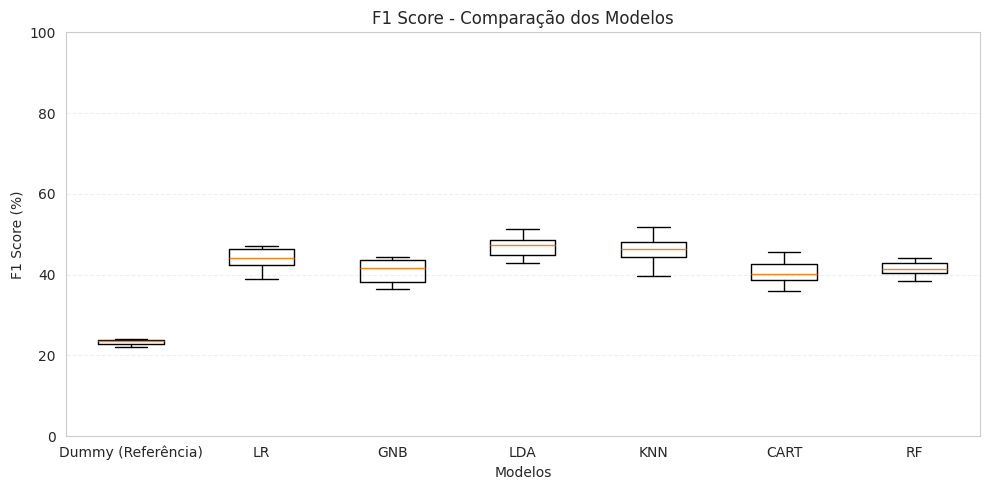

In [57]:
avaliar_modelos(X_train_doc2vec, y_train, num_folds=NUM_FOLDS, seed=SEED)

### Experimento com Bag of Words

In [58]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize

ctv = CountVectorizer(max_features=2000)

# 2. Aplicar Bag of Words
X_train_bow = ctv.fit_transform(X_train_text_processed).toarray()
X_test_bow = ctv.transform(X_test_text_processed).toarray()

In [59]:
X_train_bow.shape, X_test_bow.shape

((4673, 2000), (1169, 2000))

Dummy (Referência) - Acc: 53.69 % (+/- 2.17%) | F1: 23.28 (+/- 0.62)
LR - Acc: 64.88 % (+/- 2.10%) | F1: 55.11 (+/- 2.81)
GNB - Acc: 44.85 % (+/- 1.67%) | F1: 43.31 (+/- 1.86)
LDA - Acc: 56.99 % (+/- 2.40%) | F1: 50.19 (+/- 2.92)
KNN - Acc: 53.01 % (+/- 3.38%) | F1: 43.44 (+/- 2.50)
CART - Acc: 57.71 % (+/- 2.41%) | F1: 51.06 (+/- 2.85)
RF - Acc: 63.73 % (+/- 2.34%) | F1: 53.81 (+/- 2.54)


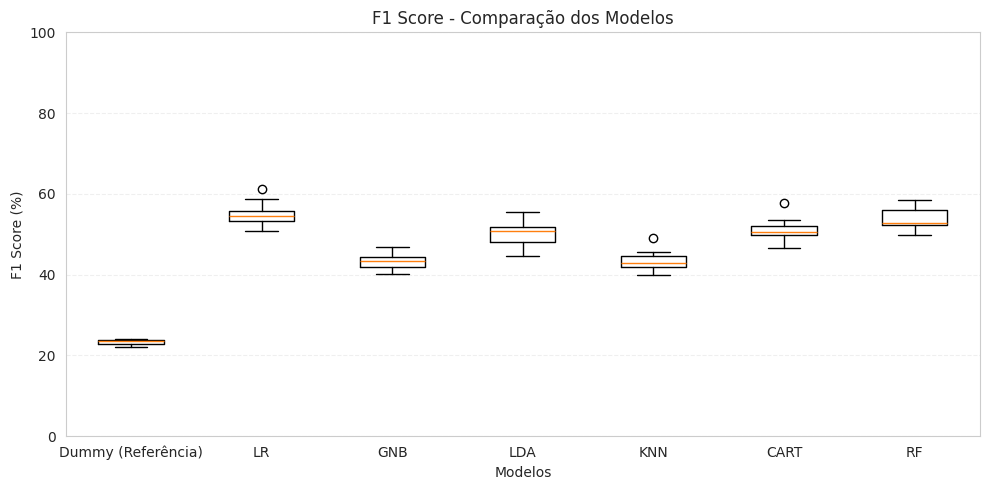

In [60]:
avaliar_modelos(X_train_bow, y_train, num_folds=NUM_FOLDS, seed=SEED)

### Experimento com Features Específicas

Dummy (Referência) - Acc: 53.69 % (+/- 2.17%) | F1: 23.28 (+/- 0.62)
LR - Acc: 61.69 % (+/- 2.28%) | F1: 48.85 (+/- 2.73)
GNB - Acc: 60.24 % (+/- 2.06%) | F1: 45.99 (+/- 2.71)
LDA - Acc: 61.61 % (+/- 2.18%) | F1: 50.74 (+/- 2.50)
KNN - Acc: 50.97 % (+/- 1.76%) | F1: 39.33 (+/- 2.01)
CART - Acc: 45.00 % (+/- 1.20%) | F1: 38.01 (+/- 1.45)
RF - Acc: 52.11 % (+/- 1.73%) | F1: 42.28 (+/- 1.25)


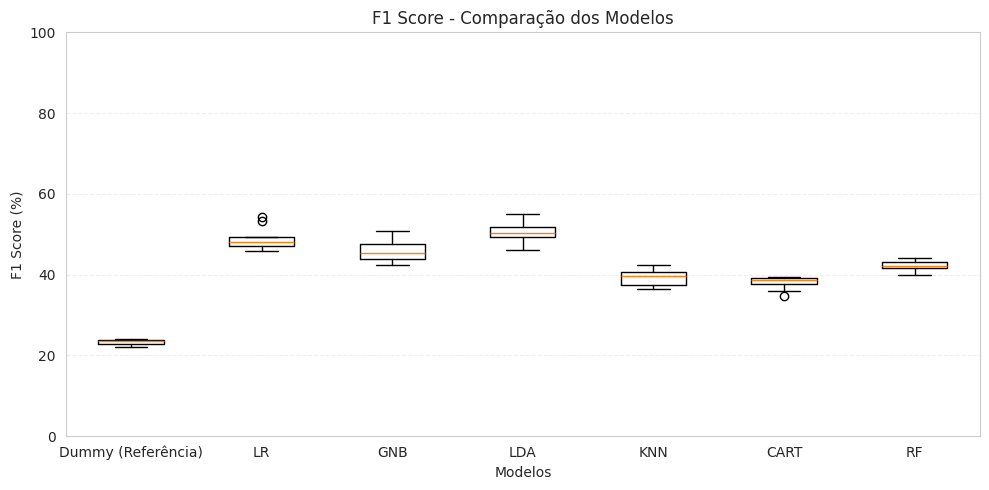

In [61]:
avaliar_modelos(X_train_num, y_train, num_folds=NUM_FOLDS, seed=SEED)

### Experimento com TF-IDF

In [62]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=500, min_df=0.00002, max_df=0.70,)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text_processed).toarray()
X_test_tfidf = tfidf_vectorizer.transform(X_test_text_processed).toarray()


Dummy (Referência) - Acc: 53.69 % (+/- 2.17%) | F1: 23.28 (+/- 0.62)
LR - Acc: 65.63 % (+/- 2.27%) | F1: 53.68 (+/- 2.70)
GNB - Acc: 43.61 % (+/- 2.59%) | F1: 43.25 (+/- 2.50)
LDA - Acc: 64.67 % (+/- 1.69%) | F1: 56.57 (+/- 1.96)
KNN - Acc: 54.02 % (+/- 5.50%) | F1: 45.18 (+/- 3.18)
CART - Acc: 54.14 % (+/- 2.40%) | F1: 46.66 (+/- 2.30)
RF - Acc: 60.90 % (+/- 2.56%) | F1: 50.14 (+/- 2.34)


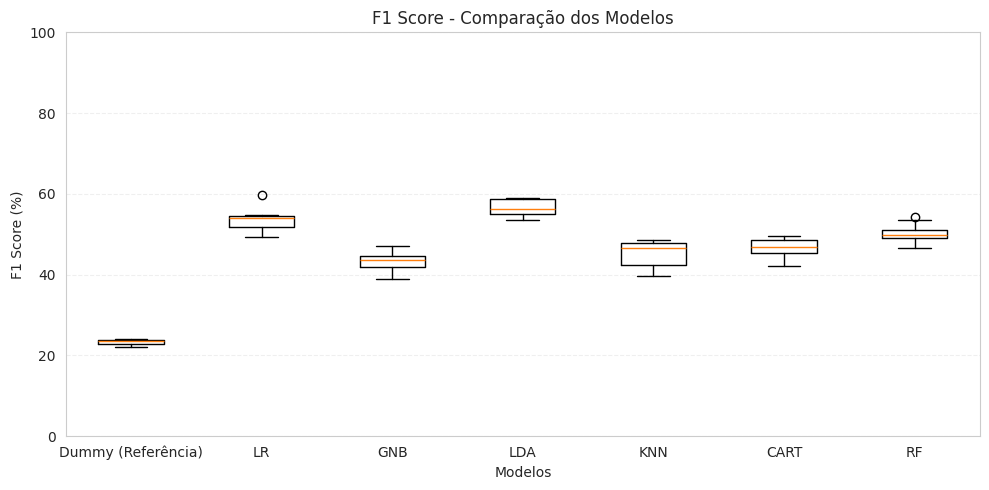

In [63]:
avaliar_modelos(X_train_tfidf, y_train, num_folds=NUM_FOLDS, seed=SEED)

### Experimento com TF-IDF + Features Específicas

Dummy (Referência) - Acc: 53.69 % (+/- 2.17%) | F1: 23.28 (+/- 0.62)
LR - Acc: 65.65 % (+/- 2.86%) | F1: 57.50 (+/- 2.78)
GNB - Acc: 42.37 % (+/- 2.57%) | F1: 42.13 (+/- 2.48)
LDA - Acc: 67.07 % (+/- 2.48%) | F1: 60.04 (+/- 2.36)
KNN - Acc: 55.15 % (+/- 2.84%) | F1: 46.31 (+/- 2.62)
CART - Acc: 55.47 % (+/- 2.37%) | F1: 48.18 (+/- 2.47)
RF - Acc: 65.74 % (+/- 1.99%) | F1: 55.63 (+/- 2.50)


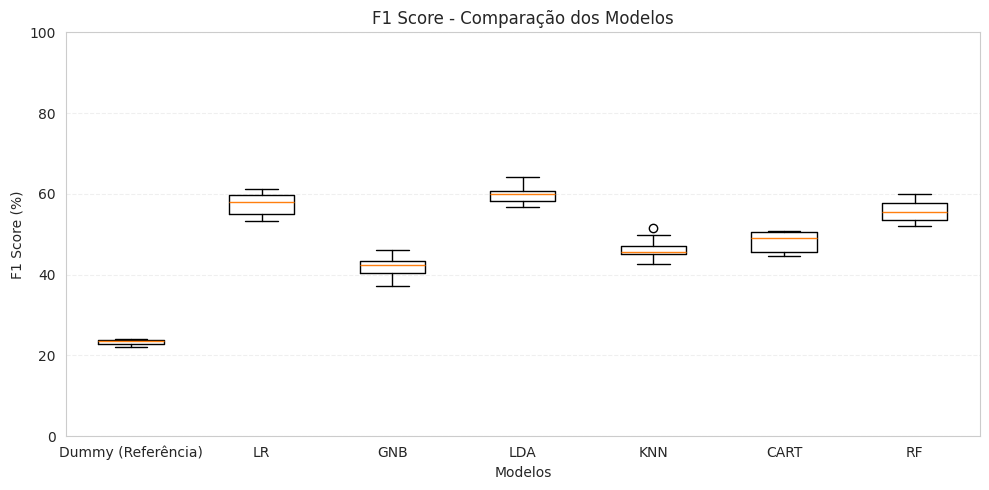

In [64]:
X_train_combined = np.hstack((X_train_tfidf, X_train_num))
X_test_combined = np.hstack((X_test_tfidf, X_test_num))

# Normalizar as features
Scaler = StandardScaler()

X_train_combined = Scaler.fit_transform(X_train_combined)
X_test_combined = Scaler.transform(X_test_combined)

avaliar_modelos(X_train_combined, y_train, num_folds=NUM_FOLDS, seed=SEED)

### Experimento com Transformer (Sentence-Embeddings)

Serão testados 3 modelos de embedding pre-treinados, dois gerais e um específico para finanças. O objetivo é verificar se o modelo específico para finanças melhora a performance do modelo de classificação, visto que ele foi treinado com textos financeiros e pode capturar melhor as nuances do sentimento financeiro.

Batches: 100%|███████████████████████████████████████████████████████████████████| 147/147 [00:01<00:00, 146.41it/s]


Dummy (Referência) - Acc: 53.69 % (+/- 2.17%) | F1: 23.28 (+/- 0.62)
LR - Acc: 71.97 % (+/- 2.09%) | F1: 65.06 (+/- 2.73)
GNB - Acc: 66.13 % (+/- 2.23%) | F1: 62.17 (+/- 2.64)
LDA - Acc: 71.00 % (+/- 2.19%) | F1: 65.42 (+/- 2.62)
KNN - Acc: 65.53 % (+/- 1.63%) | F1: 56.77 (+/- 2.46)
CART - Acc: 48.88 % (+/- 2.35%) | F1: 41.89 (+/- 1.99)
RF - Acc: 62.36 % (+/- 2.09%) | F1: 47.04 (+/- 1.73)


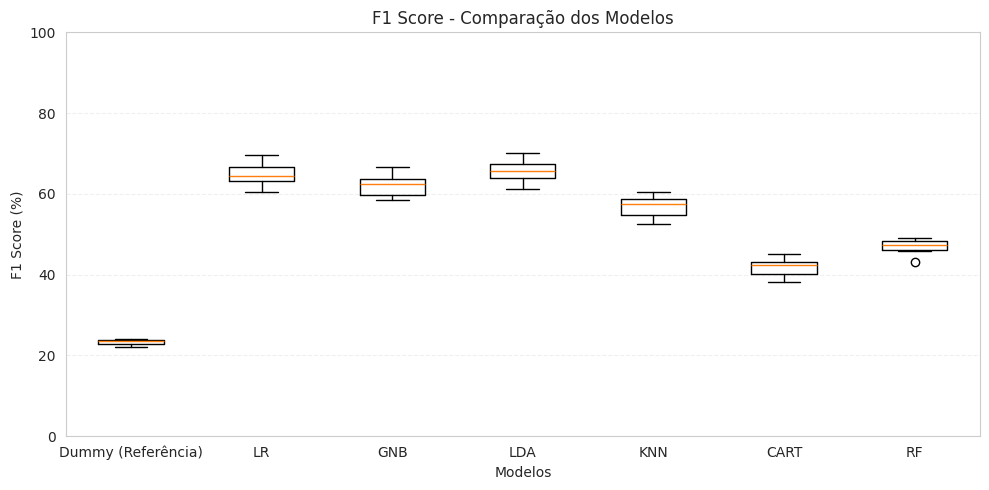

In [65]:
from sklearn.preprocessing import MinMaxScaler
encoder = SentenceTransformer("all-MiniLM-L6-v2")

# Transformar os textos em embeddings
X_train_embeddings = encoder.encode(X_train_text.tolist(), show_progress_bar=True)
X_test_embeddings = encoder.encode(X_test_text.tolist(), show_progress_bar=True)

# Normalizar os embeddings
Scaler = MinMaxScaler()
X_train_embeddings = Scaler.fit_transform(X_train_embeddings)
X_test_embeddings = Scaler.transform(X_test_embeddings)

avaliar_modelos(X_train_embeddings, y_train, num_folds=NUM_FOLDS, seed=SEED)


Batches: 100%|████████████████████████████████████████████████████████████████████| 147/147 [00:06<00:00, 23.50it/s]


Dummy (Referência) - Acc: 53.69 % (+/- 2.17%) | F1: 23.28 (+/- 0.62)
LR - Acc: 75.41 % (+/- 1.60%) | F1: 68.67 (+/- 1.96)
GNB - Acc: 73.96 % (+/- 1.99%) | F1: 70.81 (+/- 2.29)
LDA - Acc: 74.73 % (+/- 1.57%) | F1: 69.64 (+/- 2.07)
KNN - Acc: 69.40 % (+/- 1.18%) | F1: 61.42 (+/- 1.84)
CART - Acc: 54.21 % (+/- 2.12%) | F1: 46.49 (+/- 2.55)
RF - Acc: 66.96 % (+/- 2.33%) | F1: 53.36 (+/- 2.11)


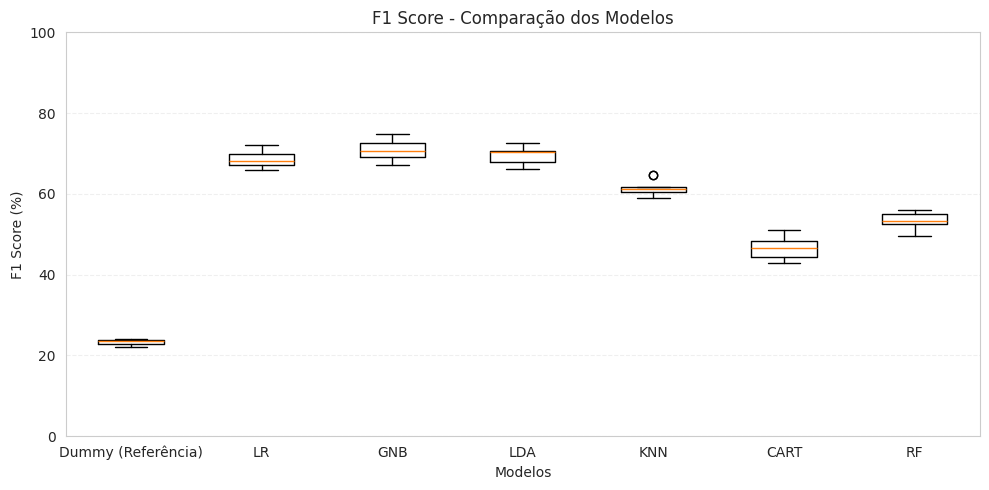

In [66]:
encoder = SentenceTransformer("all-mpnet-base-v2")

# Transformar os textos em embeddings
X_train_embeddings = encoder.encode(X_train_text.tolist(), show_progress_bar=True)
X_test_embeddings = encoder.encode(X_test_text.tolist(), show_progress_bar=True)

# Normalizar os embeddings
Scaler = MinMaxScaler()
X_train_embeddings = Scaler.fit_transform(X_train_embeddings)
X_test_embeddings = Scaler.transform(X_test_embeddings)

avaliar_modelos(X_train_embeddings, y_train, num_folds=NUM_FOLDS, seed=SEED)


In [31]:
encoder = SentenceTransformer("zeeshanabbasi2004/finbert-sentiment")

# Transformar os textos em embeddings
X_train_embeddings = encoder.encode(X_train_text.tolist(), show_progress_bar=True)
X_test_embeddings = encoder.encode(X_test_text.tolist(), show_progress_bar=True)

No sentence-transformers model found with name zeeshanabbasi2004/finbert-sentiment. Creating a new one with mean pooling.
Batches: 100%|████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 25.47it/s]


In [30]:
# Normalizar os embeddings
Scaler = MinMaxScaler()
X_train_embeddings = Scaler.fit_transform(X_train_embeddings)
X_test_embeddings = Scaler.transform(X_test_embeddings)

avaliar_modelos(X_train_embeddings, y_train, num_folds=NUM_FOLDS, seed=SEED)


No sentence-transformers model found with name zeeshanabbasi2004/finbert-sentiment. Creating a new one with mean pooling.
Batches: 100%|████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 26.77it/s]


NameError: name 'MinMaxScaler' is not defined

### Testando combinação de TF-IDF e Embedding

In [68]:
# Faz o empilhamento horizontal
X_comb_tfidf_emb = np.hstack([X_train_tfidf, X_train_embeddings])
X_comb_tfidf_emb = Scaler.fit_transform(X_comb_tfidf_emb)

Dummy (Referência) - Acc: 53.69 % (+/- 2.17%) | F1: 23.28 (+/- 0.62)
LR - Acc: 79.44 % (+/- 1.79%) | F1: 72.99 (+/- 2.64)
GNB - Acc: 64.69 % (+/- 1.12%) | F1: 63.26 (+/- 1.18)
LDA - Acc: 78.11 % (+/- 1.35%) | F1: 72.49 (+/- 1.87)
KNN - Acc: 78.96 % (+/- 1.36%) | F1: 73.22 (+/- 1.94)
CART - Acc: 69.59 % (+/- 0.96%) | F1: 63.03 (+/- 1.55)
RF - Acc: 77.83 % (+/- 1.26%) | F1: 70.44 (+/- 1.91)


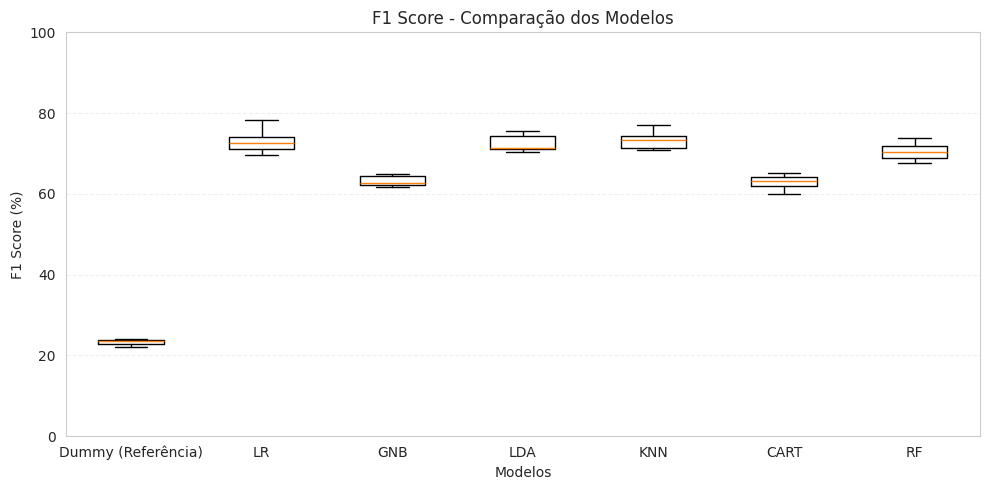

In [69]:
avaliar_modelos(X_comb_tfidf_emb, y_train, num_folds=NUM_FOLDS, seed=SEED)

### Testando Classificadores do Melhor Caso (Embeddings c/ FinBERT)

In [95]:
# Modelos
classifiers = [
    LogisticRegression(max_iter=3000, solver='liblinear', random_state=SEED),
    LinearDiscriminantAnalysis(),
    GaussianNB()
]

# Parâmetros para grid search
params = [
    # LR
    {
        "C": np.logspace(-3, 3, 7),
        "penalty": ["l1", "l2"]
    },
    # LDA
    {
        "solver": ["svd", "lsqr", "eigen"],
        "shrinkage": [None, 'auto']  # 'shrinkage' só funciona com lsqr e eigen
    },
    # GaussianNB
    {
        "var_smoothing": np.logspace(-12, -6, 7)
    }
]

In [96]:
for clf, param in zip(classifiers, params):
    name = clf.__class__.__name__
    print(f"\n=== {name} ===")

    grid = RandomizedSearchCV(clf, param, cv=3, n_jobs=-1, n_iter=14, random_state=SEED, verbose=1)
    grid.fit(X_train_embeddings, y_train.ravel())

    print(f"- Parametros Encontrados: {grid.best_params_}")

    y_pred = grid.predict(X_test_embeddings)
    acc = accuracy_score(y_test, y_pred) * 100
    f1 = f1_score(y_test, y_pred, average='macro') * 100
    prec = precision_score(y_test, y_pred, average='macro') * 100
    rec = recall_score(y_test, y_pred, average='macro') * 100

    print(f"- Acuracia: {acc:.2f}%")
    print(f"- F1 Score: {f1:.2f}%")
    print(f"- Precisão: {prec:.2f}%")
    print(f"- Recall: {rec:.2f}%")



=== LogisticRegression ===
Fitting 3 folds for each of 14 candidates, totalling 42 fits
- Parametros Encontrados: {'penalty': 'l2', 'C': 0.01}
- Acuracia: 84.00%
- F1 Score: 79.12%
- Precisão: 80.63%
- Recall: 77.97%

=== LinearDiscriminantAnalysis ===
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/home/apo-pc/anaconda3/envs/DS-Mandacaru/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=14. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/apo-pc/anaconda3/envs/DS-Mandacaru/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
3 fits failed out of a total of 18.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/home/apo-pc/anaconda3/envs/DS-Mandacaru/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_pa

- Parametros Encontrados: {'solver': 'lsqr', 'shrinkage': 'auto'}
- Acuracia: 82.55%
- F1 Score: 78.27%
- Precisão: 77.82%
- Recall: 78.85%

=== GaussianNB ===
Fitting 3 folds for each of 7 candidates, totalling 21 fits


/home/apo-pc/anaconda3/envs/DS-Mandacaru/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 7 is smaller than n_iter=14. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


- Parametros Encontrados: {'var_smoothing': 1e-12}
- Acuracia: 83.15%
- F1 Score: 81.27%
- Precisão: 79.77%
- Recall: 86.27%


=== LogisticRegression ===
Fitting 3 folds for each of 14 candidates, totalling 42 fits
- Parametros Encontrados: {'penalty': 'l2', 'C': 0.01}
- Acuracia: 84.00%
- F1 Score: 79.12%
- Precisão: 80.63%
- Recall: 77.97%

=== LinearDiscriminantAnalysis ===
Fitting 3 folds for each of 6 candidates, totalling 18 fits
- Parametros Encontrados: {'solver': 'lsqr', 'shrinkage': 'auto'}
- Acuracia: 82.55%
- F1 Score: 78.27%
- Precisão: 77.82%
- Recall: 78.85%

=== GaussianNB ===
Fitting 3 folds for each of 7 candidates, totalling 21 fits
- Parametros Encontrados: {'var_smoothing': 1e-12}
- Acuracia: 83.15%
- F1 Score: 81.27%
- Precisão: 79.77%
- Recall: 86.27%

Existe uma pequena diferença entre os desempenhos dos modelos. Enquanto o modelo de Regressão Logística apresentou uma acurácia de 84%, o modelo de Naive Bayes Gaussian teve uma acurácia de 83.15%. No entanto, o modelo de Naive Bayes Gaussian apresentou um F1 Score ligeiramente melhor (81.27%) em comparação com o modelo de Regressão Logística (79.12%).

Apesar disso, por uma questão de interpretação, o modelo Naive Bayes Gaussian apresenta uma maior dificuldade de interpretação, uma vez que acaba tendo uma confiança alta que não reflete a realidade, o que pode levar a decisões erradas. Já o modelo de Regressão Logística, apesar de não ter o melhor desempenho, é mais interpretável e pode ser mais confiável em termos de previsões.

In [42]:
melhor_CLF = GaussianNB(var_smoothing=1e-12)  # Melhor modelo encontrado
melhor_CLF.fit(X_train_embeddings, y_train)

y_pred = melhor_CLF.predict(X_test_embeddings)
acc = accuracy_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred, average='macro') * 100
prec = precision_score(y_test, y_pred, average='macro') * 100
rec = recall_score(y_test, y_pred, average='macro') * 100
print(f"- Acuracia: {acc:.2f}%")
print(f"- F1 Score: {f1:.2f}%")
print(f"- Precisão: {prec:.2f}%")
print(f"- Recall: {rec:.2f}%")


- Acuracia: 83.15%
- F1 Score: 81.27%
- Precisão: 79.77%
- Recall: 86.27%


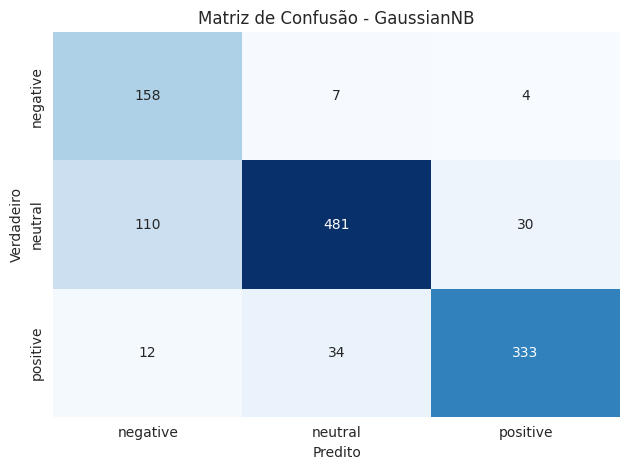

In [43]:
# Matriz de Confusão
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels=melhor_CLF.classes_)
# Plotar a matriz de confusão com Seaborn
label_names = label_encoder.inverse_transform(melhor_CLF.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_names, yticklabels=label_names)
plt.title(f"Matriz de Confusão - {melhor_CLF.__class__.__name__}")
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.tight_layout()
plt.show()

In [44]:
# Get LR probabilities for a example
y_proba = melhor_CLF.predict_proba(X_test_embeddings)
# Get the predicted class probabilities for the first 10 examples
for i in range(10):
    prob_str = ', '.join([f'{p*100:.3f}%' for p in y_proba[i]])
    print(f"Exemplo {i+1}: Probabilidades [{prob_str}] - Classe Predita: {label_encoder.inverse_transform([y_pred[i]])[0]}")

Exemplo 1: Probabilidades [0.000%, 100.000%, 0.000%] - Classe Predita: neutral
Exemplo 2: Probabilidades [100.000%, 0.000%, 0.000%] - Classe Predita: negative
Exemplo 3: Probabilidades [0.000%, 100.000%, 0.000%] - Classe Predita: neutral
Exemplo 4: Probabilidades [100.000%, 0.000%, 0.000%] - Classe Predita: negative
Exemplo 5: Probabilidades [0.000%, 100.000%, 0.000%] - Classe Predita: neutral
Exemplo 6: Probabilidades [0.000%, 100.000%, 0.000%] - Classe Predita: neutral
Exemplo 7: Probabilidades [0.000%, 100.000%, 0.000%] - Classe Predita: neutral
Exemplo 8: Probabilidades [100.000%, 0.000%, 0.000%] - Classe Predita: negative
Exemplo 9: Probabilidades [100.000%, 0.000%, 0.000%] - Classe Predita: negative
Exemplo 10: Probabilidades [0.000%, 0.000%, 100.000%] - Classe Predita: positive


Nota-se que o modelo apresenta um desempenho razoavel, confundindo classes de interesse ("Positive" e "Negative") com a classe "Neutral". Isso pode estar acontecendo devido ao desbalanceamento dos dados, onde a classe "Neutral" é a mais frequente, aliado ao fato de que o modelo não consegue capturar bem as nuances dos sentimentos expressos nos textos, especialmente quando há uma mistura de sentimentos ou quando o texto é neutro.

#### LR

In [49]:
melhor_LR = LogisticRegression(penalty='l2', C=0.01)  # Melhor modelo encontrado
melhor_LR.fit(X_train_embeddings, y_train)

y_pred = melhor_LR.predict(X_test_embeddings)
acc = accuracy_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred, average='macro') * 100
prec = precision_score(y_test, y_pred, average='macro') * 100
rec = recall_score(y_test, y_pred, average='macro') * 100
print(f"- Acuracia: {acc:.2f}%")
print(f"- F1 Score: {f1:.2f}%")
print(f"- Precisão: {prec:.2f}%")
print(f"- Recall: {rec:.2f}%")

- Acuracia: 84.35%
- F1 Score: 79.42%
- Precisão: 80.37%
- Recall: 78.64%


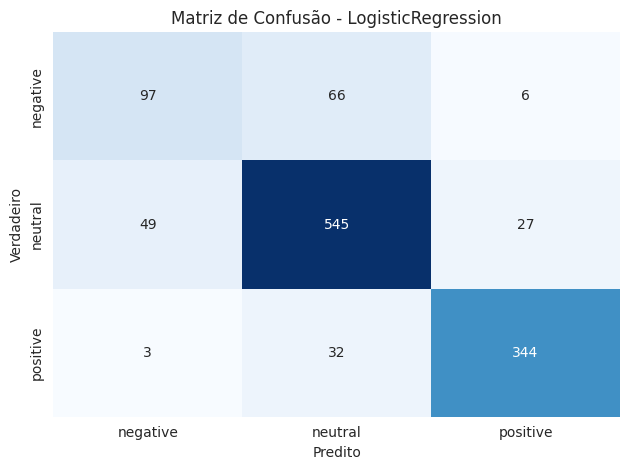

In [51]:
# Matriz de Confusão
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels=melhor_LR.classes_)
# Plotar a matriz de confusão com Seaborn
label_names = label_encoder.inverse_transform(melhor_LR.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_names, yticklabels=label_names)
plt.title(f"Matriz de Confusão - {melhor_LR.__class__.__name__}")
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.tight_layout()
plt.show()

In [47]:
# Get LR probabilities for a example
y_proba = melhor_LR.predict_proba(X_test_embeddings)
# Get the predicted class probabilities for the first 10 examples
for i in range(10):
    prob_str = ', '.join([f'{p*100:.3f}%' for p in y_proba[i]])
    print(f"Exemplo {i+1}: Probabilidades [{prob_str}] - Classe Predita: {label_encoder.inverse_transform([y_pred[i]])[0]}")

Exemplo 1: Probabilidades [4.447%, 94.115%, 1.438%] - Classe Predita: neutral
Exemplo 2: Probabilidades [39.333%, 60.391%, 0.276%] - Classe Predita: neutral
Exemplo 3: Probabilidades [0.215%, 92.832%, 6.953%] - Classe Predita: neutral
Exemplo 4: Probabilidades [22.433%, 32.292%, 45.275%] - Classe Predita: positive
Exemplo 5: Probabilidades [6.740%, 93.091%, 0.169%] - Classe Predita: neutral
Exemplo 6: Probabilidades [0.345%, 95.447%, 4.208%] - Classe Predita: neutral
Exemplo 7: Probabilidades [6.694%, 92.587%, 0.719%] - Classe Predita: neutral
Exemplo 8: Probabilidades [38.148%, 59.152%, 2.699%] - Classe Predita: neutral
Exemplo 9: Probabilidades [53.583%, 27.761%, 18.656%] - Classe Predita: negative
Exemplo 10: Probabilidades [0.001%, 0.036%, 99.963%] - Classe Predita: positive
